# CS451 Covid Prediction

This notebook contains the group project solution for the cs451 final project, which aims to predict the spread of COVID-19 in Canada through usage of large quantities of Twitter data and other sources. The collection and sentiment analysis of Twitter data is performed separately, and is then used as an extra input alongside other covid-related data with the hopes of improving the model accuracy. We have chosen to implement the techniques outlined in a paper which boasts improvements on state-of-the-art techniques, including ARIMA, Simple Moving Average witha 6-day window, and Double Exponential Moving Average. Their technique uses a bidirectional LSTM and clusters countries by demographic, socioeconomic and health sector indicators to train the model on a richer dataset. We will include the Twitter sentiment analysis as an extra feature and see if this can improve the results even further.

# Data preparation

In order to expand our dataset for better accuracy, we performed K-Means clustering on countries using several demographic, socioeconomic and health sector indicators to find countries similar to Canada. We then collected data pertaining to the degree of lockdown measures for each country as supplemental features to our model. The data consists of:

*   School closing:
   * 0: No measures.
   * 1: Safety precautions are required.
   * 2: Recommended closing.
   * 3: Require closing (only some levels/categories).
   * 4: Require closing at all levels.
*   Workplace closing:
   * 0: No measures.
   * 1: Safety precautions are required.
   * 2: Recommended closing or working from home.
   * 3: Require closing or working from home for some sectors or categories of workers.
   * 4: Require closing for all sectors except for essential workplaces.
*   Restrictions on gatherings:
   * 0: No restrictions.
   * 1: Restrictions on very large gatherings (limit > 1000 people).
   * 2: Restrictions on gatherings between 101-1000 people.
   * 3: Restrictions on gatherings between 11-100 people.
   * 4: Restrictions on gatherings of 10 people or less.
*   Public transport shutdown:
   * 0: No restrictions.
   * 1: Recommended closing or significantly reduce volume or routes or means of transportation available.
   * 2: Require closing.
*   International travel controls:
   * 0: No restrictions.
   * 1: Screening arrivals.
   * 2: Quarantine arrivals from some or all regions.
   * 3: Ban arrivals from some regions.
   * 4: Ban on all regions or total border closure.


In [1]:
from datetime import date

# Data for Canada was collected from https://www.cihi.ca/en/covid-19-intervention-timeline-in-canada
# In case of discrepancy for certain measures between provinces, the most common date
# of the measure implementation between the most populous provinces was selected.
canada_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 17), 4),
        (date(2020, 9, 8), 1),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 17), 3),
        (date(2020, 3, 25), 4),
        (date(2020, 5, 5), 3),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 16), 2),
        (date(2020, 3, 27), 4),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 16), 2),
    ],
}

new_zealand_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 2),
        (date(2020, 3, 23), 4),
        (date(2020, 5, 13), 2),
        (date(2020, 6, 8), 1),
        (date(2020, 8, 11), 3),
        (date(2020, 8, 30), 2),
        (date(2020, 9, 21), 1),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 1),
        (date(2020, 3, 25), 4),
        (date(2020, 4, 27), 1),
        (date(2020, 6, 8), 0),
        (date(2020, 8, 11), 1),
        (date(2020, 9, 21), 0),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 2),
        (date(2020, 3, 23), 4),
        (date(2020, 5, 13), 2),
        (date(2020, 6, 8), 0),
        (date(2020, 8, 11), 3),
        (date(2020, 8, 30), 2),
        (date(2020, 9, 21), 0),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 23), 1),
        (date(2020, 3, 25), 2),
        (date(2020, 4, 27), 1),
        (date(2020, 5, 13), 0),
        (date(2020, 8, 11), 1),
        (date(2020, 8, 30), 0),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 2),
        (date(2020, 3, 23), 3),
        (date(2020, 3, 25), 4),
        (date(2020, 4, 27), 3),
        (date(2020, 5, 13), 2),
        (date(2020, 6, 8), 1),
        (date(2020, 8, 11), 3),
        (date(2020, 8, 30), 2),
        (date(2020, 9, 21), 1),
    ],
}

# data collected from
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Australia
australia_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 4),
        (date(2020, 5, 15), 2),
        (date(2020, 6, 20), 3),
        (date(2020, 7, 7), 4),
        (date(2020, 10, 27), 1),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 4),
        (date(2020, 5, 15), 2),
        (date(2020, 6, 20), 3),
        (date(2020, 7, 7), 4),
        (date(2020, 10, 27), 1),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 21), 3),
        (date(2020, 5, 15), 2),
        (date(2020, 6, 20), 3),
        (date(2020, 10, 27), 1),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 2, 27), 2),
        (date(2020, 3, 21), 4),
        (date(2020, 5, 15), 2),
        (date(2020, 7, 7), 4),
        (date(2020, 10, 27), 1),
    ],
}

# data collected from 
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Iceland
iceland_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 4),
        (date(2020, 4, 21), 1),
        (date(2020, 10, 5), 4),
        (date(2020, 11, 15), 1),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 1),
        (date(2020, 3, 24), 4),
        (date(2020, 4, 21), 1),
        (date(2020, 10, 5), 4),
        (date(2020, 11, 15), 1),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 2),
        (date(2020, 3, 21), 3),
        (date(2020, 4, 21), 1),
        (date(2020, 10, 5), 3),
        (date(2020, 11, 15), 1),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 2), 2),
        (date(2020, 3, 18), 4),
        (date(2020, 4, 21), 2),
    ],
}

# data collected from 
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Cyprus
cyprus_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 4),
        (date(2020, 5, 4), 1),
        (date(2020, 11, 30), 4),
        (date(2020, 12, 4), 1),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 4),
        (date(2020, 5, 21), 1),
        (date(2020, 11, 30), 4),
        (date(2020, 12, 4), 1),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 3),
        (date(2020, 5, 21), 2),
        (date(2020, 11, 30), 3),
        (date(2020, 12, 4), 0),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 13), 4),
        (date(2020, 5, 21), 2),
        (date(2020, 11, 30), 4),
        (date(2020, 12, 4), 2),
    ],
}

# data collected from 
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_New_York_(state)
# https://www.nbcnews.com/health/health-news/here-are-stay-home-orders-across-country-n1168736
us_lockdown_measures = {
    'school-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 4, 10), 4),
        (date(2020, 9, 4), 3),
    ],
    'workplace-closing': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 20), 4),
        (date(2020, 6, 8), 2),
        (date(2020, 6, 22), 0),
    ],
    'gatherings': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 20), 4),
        (date(2020, 6, 22), 2),
        (date(2020, 7, 10), 1),
    ],
    'public-transport': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 20), 2),
    ],
    'international-travel': [
        (date(2020, 1, 23), 0),
        (date(2020, 3, 19), 2),
    ],
}

In [2]:
from datetime import timedelta
import pandas as pd
import numpy as np

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

measures = ['school-closing', 'workplace-closing', 'gatherings', 'public-transport', 'international-travel']

def generate_time_series(lockdown_measures, start_date=date(2020, 1, 23), end_date=date(2020, 12, 10)):
    data = {
        'school-closing': [],
        'workplace-closing': [],
        'gatherings': [],
        'public-transport': [],
        'international-travel': [],
    }
    data['date'] = list(daterange(start_date, end_date))
    for measure in measures:
        curr_date = start_date
        curr_val = 0
        for d, val in lockdown_measures[measure]:
            data[measure] += [curr_val for _ in daterange(curr_date, d)]
            curr_date = d
            curr_val = val
        if curr_date < end_date:
            data[measure] += [curr_val for _ in daterange(curr_date, end_date)]
    return pd.DataFrame.from_dict(data)

canada_df = generate_time_series(canada_lockdown_measures)
new_zealand_df = generate_time_series(new_zealand_lockdown_measures)
australia_df = generate_time_series(australia_lockdown_measures)
iceland_df = generate_time_series(iceland_lockdown_measures)
cyprus_df = generate_time_series(cyprus_lockdown_measures)
us_df = generate_time_series(us_lockdown_measures)

In [3]:
from datetime import datetime

def get_twitter_sentiment(path='./twitter-sentiment.csv'):
    df = pd.read_csv(path)
    data = {}
    for _, row in df.iterrows():
        cc = row['countrycode']
        start_date = datetime.strptime(str(row['startdate']), '%Y%m%d').date()
        end_date = datetime.strptime(str(row['enddate']), '%Y%m%d').date() + timedelta(1)
        avg_p = row['avg_polarity']
        avg_s = row['avg_subjectivity']
        pc = row['positive_count']
        nc = row['negative_count']
        new_row = [(d, avg_p, avg_s, pc, nc) for d in daterange(start_date, end_date)]
        if cc not in data:
            data[cc] = {
                'date': [],
                'avg_polarity': [],
                'avg_subjectivity': [],
                'positive_count': [],
                'negative_count': [],
            }
        for x in new_row:
            data[cc]['date'].append(x[0])
            data[cc]['avg_polarity'].append(x[1])
            data[cc]['avg_subjectivity'].append(x[2])
            data[cc]['positive_count'].append(x[3])
            data[cc]['negative_count'].append(x[4])
    for k in data.keys():
        data[k] = pd.DataFrame.from_dict(data[k])
    return data

twitter_sentiment = get_twitter_sentiment()


In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

# Set seed to ensure our results are reproducible
np.random.seed(42)

# Merge total cases dataframe with lockdown measure dataframe
def merge_dfs(lockdown_measures_df, twitter_sentiment, total_cases_worldwide_df, location):
    df = total_cases_worldwide_df[total_cases_worldwide_df['location'] == location].dropna()
    df['date'] = [datetime.strptime(x, '%Y-%m-%d').date() for x in df['date']]
    merged_df = df.merge(lockdown_measures_df, how='left', on='date').dropna()
    merged_df = twitter_sentiment.merge(merged_df, how='left', on='date').dropna()
    merged_df = merged_df.drop(columns=['location', 'date'])
    merged_vals = np.array(merged_df[[
        'school-closing',
        'workplace-closing',
        'gatherings',
        'public-transport',
        'international-travel',
        'avg_polarity',
        'avg_subjectivity',
        'total_cases',
    ]].values)
    return merged_vals

total_cases_worldwide_df = pd.read_csv('world-covid-data.csv', usecols=['location', 'total_cases', 'date'])

canada_data = merge_dfs(canada_df, twitter_sentiment['CA'], total_cases_worldwide_df, 'Canada')
new_zealand_data = merge_dfs(canada_df, twitter_sentiment['NZ'], total_cases_worldwide_df, 'New Zealand')
australia_data = merge_dfs(australia_df, twitter_sentiment['AU'], total_cases_worldwide_df, 'Australia')
iceland_data = merge_dfs(iceland_df, twitter_sentiment['IS'], total_cases_worldwide_df, 'Iceland')
cyprus_data = merge_dfs(cyprus_df, twitter_sentiment['CY'], total_cases_worldwide_df, 'Cyprus')
us_data = merge_dfs(us_df, twitter_sentiment['US'], total_cases_worldwide_df, 'United States')

data = np.concatenate((canada_data, new_zealand_data, australia_data, iceland_data, cyprus_data, us_data), axis=0)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from itertools import islice

# Since LSTMs are sensitive to the scale of the input data,
# we normalize the inputs:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

len_to_split = [len(canada_data), len(new_zealand_data), len(australia_data), len(iceland_data), len(cyprus_data), len(us_data)]
inputt = iter(scaled_data)# iter(scaled_data)
split_data = [list(islice(inputt, elem)) for elem in len_to_split]
canada_data = split_data[0]
new_zealand_data = split_data[1]
australia_data = split_data[2]
iceland_data = split_data[3]
cyprus_data = split_data[4]
us_data = split_data[5]

Our input data will be a sequence of values, and our output will be the single value for the cumulative COVID-19 cases. Given input data $\{x_1, x_2, ..., x_{n-1}\}$ and output data $\{y_1, y_2, ..., y_n\}$, if we would like to predict a value $y_i$, we will use a sequence $x_{i-k-1},...,x_{i-1}$ to make the prediction. For this purpose, we have defined the `create_dataset` method to reshape the data in this format, where `look_back` corresponds to $k$.

In [6]:
def create_dataset(data, look_back=1, test_size=.25, val_size=.2):
    data = np.expand_dims(data, axis=1)
    data_x, data_y = [], []
    for i in range(len(data) - look_back-1):
        a = data[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(data[i + 1:i + look_back + 1, 0, -1])
    

    data_x = np.array(data_x)
    data_y = np.array(data_y)
    test_len = int(len(data) * test_size)
    val_len = int((len(data) - test_len) * val_size)
    train_len = len(data) - test_len - val_len
    train_x = np.array(data_x[0:train_len,:])
    val_x = np.array(data_x[train_len:train_len+val_len,:])
    test_x = np.array(data_x[train_len+val_len:,:])
    train_y = np.array(data_y[0:train_len])
    val_y = np.array(data_y[train_len:train_len+val_len])
    test_y = np.array(data_y[train_len+val_len:])
    return train_x, val_x, test_x, train_y, val_y, test_y

look_back=7
ca_train_x, ca_val_x, ca_test_x, ca_train_y, ca_val_y, ca_test_y = create_dataset(canada_data, look_back)
nz_train_x, nz_val_x, nz_test_x, nz_train_y, nz_val_y, nz_test_y = create_dataset(new_zealand_data, look_back)
au_train_x, au_val_x, au_test_x, au_train_y, au_val_y, au_test_y = create_dataset(australia_data, look_back)
il_train_x, il_val_x, il_test_x, il_train_y, il_val_y, il_test_y = create_dataset(iceland_data, look_back)
cy_train_x, cy_val_x, cy_test_x, cy_train_y, cy_val_y, cy_test_y = create_dataset(cyprus_data, look_back)
us_train_x, us_val_x, us_test_x, us_train_y, us_val_y, us_test_y = create_dataset(us_data, look_back)


train_x = np.concatenate((
    ca_train_x,
    nz_train_x,
    au_train_x,
    il_train_x,
    cy_train_x,
    us_train_x,
    ),
    axis=0
)
test_x = np.concatenate((
    ca_test_x,
    nz_test_x,
    au_test_x,
    il_test_x,
    cy_test_x,
    us_test_x,
    ),
    axis=0
)
val_x = np.concatenate((
    ca_val_x,
    nz_val_x,
    au_val_x,
    il_val_x,
    cy_val_x,
    us_val_x,
    ),
    axis=0
)
train_y = np.concatenate((
    ca_train_y,
    nz_train_y,
    au_train_y,
    il_train_y,
    cy_train_y,
    us_train_y,
    ),
    axis=0
)
test_y = np.concatenate((
    ca_test_y,
    nz_test_y,
    au_test_y,
    il_test_y,
    cy_test_y,
    us_test_y,
    ),
    axis=0
)
val_y = np.concatenate((
    ca_val_y,
    nz_val_y,
    au_val_y,
    il_val_y,
    cy_val_y,
    us_val_y,
    ),
    axis=0
)


Next we define a dataset class inheriting from `torch.utils.data.Dataset`, which will make loading data for training a cleaner and easier process. 

In [7]:
from torch.utils.data import Dataset, DataLoader

class CovidDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]).to(device), \
            torch.FloatTensor([self.targets[idx]]).to(device)

In [8]:
batch_size=32
train_loader = DataLoader(CovidDataset(train_x, train_y), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(CovidDataset(test_x, test_y), shuffle=False, batch_size=batch_size)
val_loader = DataLoader(CovidDataset(val_x, val_y), shuffle=False, batch_size=batch_size)

# Model
Now that our data is formatted we will create the model and perform the training.

In [9]:
import torch

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
import copy
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from math import inf

# Define the model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_len=1, batch_size=1, device=None, verbose=False):
        super(BiLSTM, self).__init__()

        self.is_training = False

        # Number of features
        self.input_size = input_size

        # Number of features in hidden state
        self.hidden_size = hidden_size

        # Number of stacked recurrent layers
        self.num_layers = num_layers

        # Size of each input sequence 
        self.seq_len = seq_len
        self.batch_size = batch_size

        self.device = device
        self.verbose = verbose
        
        # We use a bidirectional LSTM to continuously update older predictions
        # based on newer data, which will hopefully improve accuracy by using
        # greater context.
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            bidirectional=True,
            batch_first=True
        )

        # The input to the linear layer will be the output of the LSTM.
        # Since we are using a bidirectional LSTM, we will have both the outputs
        # of the forward-LSTM and the backward-LSTM concatenated, which we will then
        # use to create our prediction. This is why the input size is twice the
        # size of the hidden output dimension. Our output size is 1 since we are
        # performing regression, and need a single value.
        self.fc = nn.Linear(hidden_size * 2, 1)

        self.relu = nn.ReLU()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(self.device),
            torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(self.device))
    
    def gaussian(self, ins, stddev=0.05):
        if self.is_training:
            return ins + Variable(torch.randn(ins.size()).cuda() * stddev)
        return ins
    
    def forward(self, x):
        out, _ = self.lstm(x.view(-1, self.seq_len, self.input_size))#, self.hidden)

        #self.hidden = (hn.detach(), cn.detach())

        #out = self.gaussian(out)
        #out = self.relu(out)
        out = self.fc(out.view(-1, self.seq_len, self.hidden_size * 2))
        return out
    
    def train(
        self,
        opt,
        criterion,
        train_loader,
        val_loader=None,
        epochs=50,
        ):
        train_losses = []
        val_losses = []
        smallest_loss = inf
        best_model = None
        for epoch in range(epochs):
            self.hidden = self.init_hidden()
            train_loss = 0
            train_steps = 0
            self.is_training = True
            for data, target in train_loader:
                opt.zero_grad()
        
                # Forward
                prediction = self.forward(data)
                if self.hidden[0].shape[0] != self.batch_size:
                    self.hidden = self.init_hidden()
        
                # Calculate loss
                loss = criterion(prediction.squeeze(), target.squeeze())
        
                # Backpropagate
                loss.backward()
        
                # Perform Adam step
                opt.step()
        
                train_loss += loss.item()
                train_steps += 1
        
            train_losses += [train_loss / train_steps]
        

            if val_loader is not None:
                self.hidden = self.init_hidden()
                val_loss = 0
                val_steps = 0
                self.is_training = False
                with torch.no_grad():
                    for data, target in val_loader:
            
                        # Calculate prediction
                        prediction = self.forward(data)
                        if self.hidden[0].shape[0] != self.batch_size:
                            self.hidden = self.init_hidden()
                        
                        # Calculate loss
                        loss = criterion(prediction.squeeze(), target.squeeze())
            
                        val_loss += loss.item()
                        val_steps += 1
                
                val_losses += [val_loss / val_steps]
                if val_losses[-1] < smallest_loss:
                    smallest_loss = val_losses[-1]
                    best_model = copy.deepcopy(self)
            
            if self.verbose:
                if val_loader is not None:
                    print('[INFO] epoch: {}, train loss: {:.10f}, val loss: {:.10f}'.format(epoch, train_losses[-1], val_losses[-1]))
                else:
                    print('[INFO] epoch: {}, train loss: {:.5f}'.format(epoch, train_losses[-1]))
        print('[INFO] Finished training! Smallest loss: {:.10f}'.format(smallest_loss))
        return train_losses, val_losses, best_model


In [11]:
import torch.optim as optim

epochs = 1000
batch_size = 1
input_size = test_x.shape[2]
num_layers = 2
hidden_size = 256

#model = BiLSTM(input_size, hidden_size, num_layers, look_back, batch_size)
#model.to(device)

#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
import os.path
from ray import tune

epochs = 1000

def train_model(config, checkpoint_dir=None, train_loader=None, val_loader=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BiLSTM(input_size, config['hidden_size'], config['num_layers'], look_back, batch_size, device)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, 'checkpoint')
        )
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    for epoch in range(epochs):
        model.hidden = model.init_hidden()
        running_loss = 0.
        epoch_steps = 0
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
    
            # Forward
            prediction = model(data)
    
            # Calculate loss
            loss = criterion(prediction.squeeze(), target.squeeze())
    
            # Backpropagate
            loss.backward()
    
            # Perform Adam step
            optimizer.step()
    
            running_loss += loss.item()
            epoch_steps += 1
    
        model.hidden = model.init_hidden()
        val_loss = 0.
        val_steps = 0
        with torch.no_grad():
            for i, (data, target) in enumerate(val_loader):
                # Calculate prediction
                prediction = model(data)
                
                # Calculate loss
                loss = criterion(prediction.squeeze(), target.squeeze())

                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss=(val_loss / val_steps))
        print('[INFO] epoch: {}, train loss: {:.5f}, val loss: {:.5f}'.format(epoch, running_loss / epoch_steps, val_loss / val_steps))
    print('[INFO] Finished training')

In [13]:
def test_loss(model):
    loss = 0.
    steps = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data, target in test_loader:
            prediction = model(data)
            loss += criterion(prediction.squeeze(), target.squeeze()).item()
            steps += 1
    return loss / steps


In [14]:
from ray.tune import CLIReporter

config = {
    'hidden_size': tune.grid_search([32, 64, 128, 256]),
    'num_layers': tune.grid_search([1, 2, 3, 4]),
    'lr': tune.grid_search([1e-3,1e-4,1e-5]),
}

reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])

#result = tune.run(
#    tune.with_parameters(train_model, train_loader=train_loader, val_loader=val_loader),
#    config=config,
#    progress_reporter=reporter,
#    resources_per_trial={'cpu': 2, 'gpu': 1},
#)


[INFO] epoch: 0, train loss: 0.0542679038, val loss: 0.2616716186
[INFO] epoch: 1, train loss: 0.0458077028, val loss: 0.2351563655
[INFO] epoch: 2, train loss: 0.0400058262, val loss: 0.2132934019
[INFO] epoch: 3, train loss: 0.0358322106, val loss: 0.1951789756
[INFO] epoch: 4, train loss: 0.0320855716, val loss: 0.1790489839
[INFO] epoch: 5, train loss: 0.0282226312, val loss: 0.1633790888
[INFO] epoch: 6, train loss: 0.0240691439, val loss: 0.1470255234
[INFO] epoch: 7, train loss: 0.0196275865, val loss: 0.1292509348
[INFO] epoch: 8, train loss: 0.0150437540, val loss: 0.1098304811
[INFO] epoch: 9, train loss: 0.0106538440, val loss: 0.0893020338
[INFO] epoch: 10, train loss: 0.0070024946, val loss: 0.0692796835
[INFO] epoch: 11, train loss: 0.0046553083, val loss: 0.0523837288
[INFO] epoch: 12, train loss: 0.0037008070, val loss: 0.0410614326
[INFO] epoch: 13, train loss: 0.0035039832, val loss: 0.0357103556
[INFO] epoch: 14, train loss: 0.0034101852, val loss: 0.0343107876
[INFO

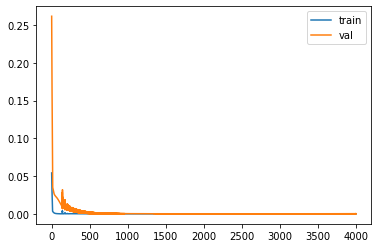

Best trial test set loss: 5.772596227870963e-05


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [16]:
from matplotlib import pyplot as plt
best_num_layers = 2
best_lr = 1e-4
best_hidden_size = 128

best_model = BiLSTM(
    input_size,
    best_hidden_size,
    best_num_layers,
    look_back,
    device=device,
    verbose=True,
    batch_size=batch_size
).to(device)

criterion = nn.MSELoss()
opt = optim.Adam(best_model.parameters(), lr=best_lr)

train_losses, val_losses, best_trained_model = best_model.train(opt, criterion, train_loader, test_loader, epochs=4000)

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

test_l = test_loss(best_trained_model)
print("Best trial test set loss: {}".format(test_l))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


[INFO] epoch: 0, train loss: 0.0000300045, val loss: 0.0000566547
[INFO] epoch: 1, train loss: 0.0000073561, val loss: 0.0000631752
[INFO] epoch: 2, train loss: 0.0000027403, val loss: 0.0001082601
[INFO] epoch: 3, train loss: 0.0000028043, val loss: 0.0001306378
[INFO] epoch: 4, train loss: 0.0000024420, val loss: 0.0001263088
[INFO] epoch: 5, train loss: 0.0000023867, val loss: 0.0001190410
[INFO] epoch: 6, train loss: 0.0000023181, val loss: 0.0001184424
[INFO] epoch: 7, train loss: 0.0000022695, val loss: 0.0001223845
[INFO] epoch: 8, train loss: 0.0000022355, val loss: 0.0001269435
[INFO] epoch: 9, train loss: 0.0000022179, val loss: 0.0001304761
[INFO] epoch: 10, train loss: 0.0000021946, val loss: 0.0001334444
[INFO] epoch: 11, train loss: 0.0000021692, val loss: 0.0001367132
[INFO] epoch: 12, train loss: 0.0000021460, val loss: 0.0001404139
[INFO] epoch: 13, train loss: 0.0000021244, val loss: 0.0001442101
[INFO] epoch: 14, train loss: 0.0000021030, val loss: 0.0001479781
[INFO

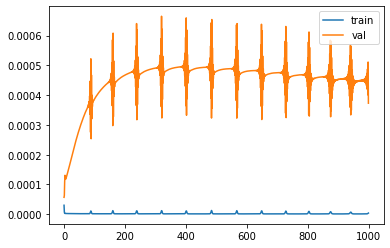

Best trial test set loss: 5.6654744525985734e-05


In [17]:
criterion = nn.MSELoss()
opt = optim.Adam(best_trained_model.parameters(), lr=1e-5)

train_losses, val_losses, best_trained_model_2 = best_trained_model.train(opt, criterion, train_loader, test_loader, epochs=1000)

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

test_l = test_loss(best_trained_model_2)
print("Best trial test set loss: {}".format(test_l))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


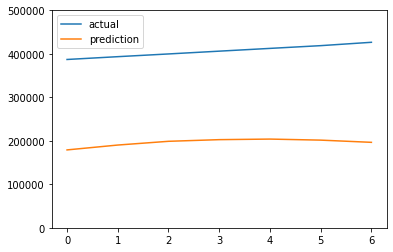

Test RMSE: 210409.884


In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

test_range_start = date(2020, 11, 30)
test_range_end = date(2020, 12, 8)
#test_range_end = date(2020, 12, 8)

df = generate_time_series(canada_lockdown_measures)
df = df[df['date'] >= test_range_start]
df = df[df['date'] <= test_range_end]
data = merge_dfs(df, twitter_sentiment['CA'], total_cases_worldwide_df, 'Canada')
data_scaled = scaler.transform(data)

xs, _, _, ys, _, _= create_dataset(data_scaled, look_back, test_size=0., val_size=0.)

xs = torch.FloatTensor(xs).to(device)

with torch.no_grad():
    prediction = best_trained_model_2(xs)

    actual = np.zeros(shape=(xs.shape[1], xs.shape[2]))
    actual[:,-1] = ys[0]
    actual = scaler.inverse_transform(actual)[:,-1]

    preds = np.zeros(shape=(xs.shape[1], xs.shape[2]))
    prediction = prediction.squeeze().cpu().numpy()
    preds[:,-1] = prediction
    preds = scaler.inverse_transform(preds)[:, -1]

    plt.plot(actual, label='actual')
    plt.plot(preds, label='prediction')
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0, 500000])
    plt.show()

    rmse = sqrt(mean_squared_error(actual, preds))
    print('Test RMSE: %.3f' % rmse)
